In [67]:
from plotly_calplot import calplot

from common.explore import display_sql

In [68]:
display_sql(f'''
CREATE OR REPLACE VIEW test_changelog AS
WITH
   normalized_with_previous AS (
    SELECT job_id,
           location_name,
           company_name,
           technology_name,
           online_at,
           online_at - INTERVAL 1 DAY AS previous_day
      FROM normalized_online_job_months_3
     --WHERE online_at >= current_date - INTERVAL 30 DAY
), min_online_at AS (
    SELECT MIN(online_at)
      FROM normalized_with_previous
), max_online_at AS (
    SELECT MAX(online_at)
      FROM normalized_with_previous
), joined_normalized_with_previous AS (
    SELECT DISTINCT
           c.job_id,
           c.online_at,
           c.location_name,
           c.company_name,
           c.technology_name,
           p.location_name AS previous_location_name,
           p.company_name AS previous_company_name,
           p.technology_name AS previous_technology_name,
           p.online_at AS previous_online_at,
           p.job_id AS previous_job_id
      FROM normalized_with_previous c
      FULL OUTER JOIN normalized_with_previous p
        ON (c.job_id = p.job_id AND
            c.location_name = p.location_name AND
            c.company_name = p.company_name AND
            c.technology_name = p.technology_name AND
            c.previous_day = p.online_at)
)
SELECT COALESCE(job_id, previous_job_id) AS job_id,
       COALESCE(location_name, previous_location_name) AS location_name,
       COALESCE(company_name, previous_company_name) AS company_name,
       COALESCE(technology_name, previous_technology_name) AS technology_name,
       COALESCE(online_at, previous_online_at) AS online_at,
       previous_job_id IS NULL AS added,
       job_id IS NULL AS deleted
  FROM joined_normalized_with_previous
 WHERE NOT (job_id IS NULL AND previous_online_at IN (SELECT * FROM max_online_at))
   AND NOT (previous_online_at IS NULL AND online_at IN (SELECT * FROM min_online_at))
''', read_only=False)

,Count


In [69]:
df = display_sql(f'''
SELECT online_at,
       added,
       deleted,
       COUNT(DISTINCT job_id)
  FROM test_changelog
-- WHERE added OR deleted
 GROUP BY 1, 2, 3
 ORDER BY 1, 2, 3
''')
df

,online_at,added,deleted,count(DISTINCT job_id)
0,2022-07-21,False,True,3529
1,2022-07-22,False,False,131475
2,2022-07-22,False,True,5150
3,2022-07-22,True,False,3994
4,2022-07-23,False,False,130319
...,...,...,...,...
268,2022-10-19,False,False,145453
269,2022-10-19,False,True,1572
270,2022-10-19,True,False,3850
271,2022-10-20,False,False,147725


In [70]:
df = display_sql(f'''
SELECT online_at,
       COUNT(DISTINCT job_id) AS added
  FROM test_changelog
 WHERE added
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,added
0,2022-07-22,3994
1,2022-07-23,1185
2,2022-07-24,241
3,2022-07-25,2844
4,2022-07-26,4038
...,...,...
86,2022-10-16,580
87,2022-10-17,3409
88,2022-10-18,4133
89,2022-10-19,3850


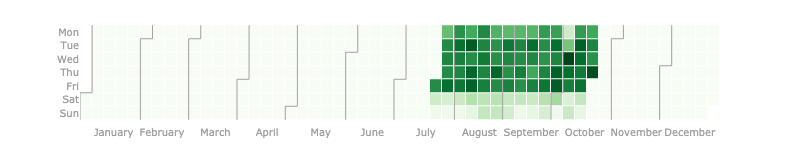

In [71]:
fig = calplot(
    df,
    x='online_at',
    y='added',
    colorscale='Greens'
)
fig.show('png')

In [72]:
df = display_sql(f'''
SELECT online_at,
       COUNT(DISTINCT job_id) AS deleted
  FROM test_changelog
 WHERE deleted
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,deleted
0,2022-07-21,3529
1,2022-07-22,5150
2,2022-07-23,3998
3,2022-07-24,3657
4,2022-07-25,3328
...,...,...
86,2022-10-15,3876
87,2022-10-16,3178
88,2022-10-17,3154
89,2022-10-18,1732


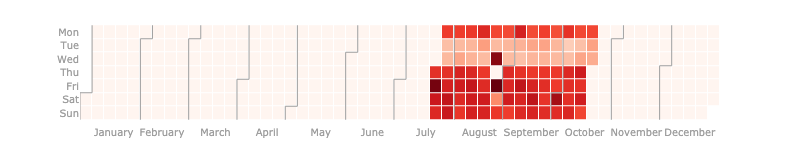

In [73]:
fig = calplot(
    df,
    x='online_at',
    y='deleted',
    colorscale='Reds'
)
fig.show('png')

In [74]:
display_sql(f'''
DROP VIEW test_changelog
''', read_only=False)

,Success
